# HSE 2021: Mathematical Methods for Data Analysis

## Homework 4

**Warning 1**: You have 2 weeks for this assignemnt.  **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells


### Contents

#### Decision Trees - 7 points
* [Task 1](#task1) (0.5 points)
* [Task 2](#task2) (0.5 points)
* [Task 3](#task3) (2 points)
* [Task 4](#task4) (0.5 points)
* [Task 5](#task5) (0.5 points)
* [Task 6](#task6) (2 points)
* [Task 7](#task7) (0.5 points)
* [Task 8](#task8) (0.5 points)

#### Ensembles - 3 points
* [Task 1](#task2_1) (1 point)
* [Task 2](#task2_2) (0.7 points)
* [Task 3](#task2_3) (0.5 points)
* [Task 4](#task2_4) (0.7 points)
* [Task 5](#task2_5) (0.1 points)

In [153]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['figure.figsize'] = (11, 5)
%matplotlib inline

In [154]:
%pip install graphviz
import graphviz

# for tree visualisation

Note: you may need to restart the kernel to use updated packages.


In [155]:
%pip install catboost

Note: you may need to restart the kernel to use updated packages.


# Part 1. Decision Tree Regressor

In this task you will be implementing decision tree for the regression by hand. 

### Task 1 <a id="task1"></a> (0.5 points)

Here you should implement the function `H()` which calculates impurity criterion. We will be training regression tree, and will take mean absolute deviation as impurity criterion.

* You cannot use loops
* If `y` is empty, the function should return 0

In [156]:
def H(y):
    """
    Calculate impurity criterion
    
    Parameters
    ----------
    y : np.array
        array of objects target values in the node

    Returns
    -------
    H(R) : float
        Impurity in the node (measuread by variance)
    """
    if not y.size:
        return 0

    return np.mean((y-y.mean())**2)


In [157]:
# Test the function
assert np.allclose(H(np.array([4, 2, 2, 2])), 0.75)
assert np.allclose(H(np.array([])), 0.0)

### Task 2 <a id="task2"></a>  (0.5 points)

To find the best split in the node we need to calculate the cost function. Denote: 
- `R` all the object in the node
- `j` index of the feature selected for the split
- `t` threshold
- `R_l` and `R_r` objects in the left and right child nodes correspondingly

We get the following cost function:

$$
Q(R, j, t) =\frac{|R_\ell|}{|R|}H(R_\ell) + \frac{|R_r|}{|R|}H(R_r) \to \min_{j, t},
$$

Implement the function `Q`, which should calculate value of the cost function for a given feature and threshold.

In [158]:
def Q(X, y, j, t):
    """
    Calculate cost function
    Parameters
    ----------
    X : ndarray
        array of objects in the node 
    y : ndarray
        array of target values in the node 
    j : int
        feature index (column in X)
    t : float
        threshold

    Returns
    -------
    Q : float
        Value of the cost function
    """   
    R_l = y[X[:, j] <= t]
    R_r = y[X[:, j] > t]
    Q = len(R_l) * H(R_l) / len(y) + len(R_r) * H(R_r) / len(y)
    return Q

### Task 3 <a id="task3"></a>  (2 points)

Now, let's implement `MyDecisionTreeRegressor` class. More specifically, you need to implement the following methods:

- `best_split`
- `grow_tree`
- `get_prediction`

Also, please add `min_samples_leaf` parameter to your class

Read docstrings for more details. Do not forget to use function `Q` implemented above, when finding the `best_split`

In [159]:
class Node(object):
    """
    Class for a decision tree node.
    
    Parameters
    ----------
    right : Node() or None
        Right child
    right : Node() or None
        Left child
    threshold: float
        
    column: int
        
    depth: int
        
    prediction: float
        prediction of the target value in the node 
        (average values calculated on a train dataset)
    is_terminal: bool
        indicates whether it is a terminal node (leaf) or not
    """    
    def __init__(self):        
        self.right = None
        self.left = None
        self.threshold = None
        self.column = None
        self.depth = None
        self.is_terminal = False
        self.prediction = None
        
    def __repr__(self):
        if self.is_terminal:
            node_desc = 'Pred {:.2f}'.format(self.prediction)
        else:
            node_desc = 'Col {}\nThreshold {:.2f}\nPred {:.2f}'. \
            format(self.column, self.threshold, self.prediction)
        return node_desc

In [160]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class MyDecisionTreeRegressor(RegressorMixin, BaseEstimator):
    """
    Class for a Decision Tree Regressor.

    Parameters
    ----------
    max_depth : int
        Max depth of a decision tree.
    min_samples_split : int
        Minimal number of samples (objects) in a node to make a split.
    """ 
    def __init__(self, max_depth=3, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
            
    def best_split(self, X, y):
        """
        Find the best split in terms of Q of data in a given decision tree node. 
        Try all features and thresholds. 
        
        Parameters
        ----------
        X : ndarray, shape (n_objects, n_features)
            Objects in the parent node
        y : ndarray, shape (n_objects, )
            1D array with the object labels. 
            
        Returns
        -------
        best_split_column : int
            Index of the best split column
        best_threshold : float
            The best split condition.
        X_left : ndarray, shape (n_objects_l, n_features)
            Objects in the left child
        y_left : ndarray, shape (n_objects_l, )
            Objects labels in the left child. 
        X_right : ndarray, shape (n_objects_r, n_features)
            Objects in the right child
        y_right : ndarray, shape (n_objects_r, )
            Objects labels in the right child. 
        """
        
        # To store best split parameters
        best_split_column = None
        best_threshold = None
        # without splitting
        best_cost = H(y) 
        
        X_left, y_left, X_right, y_right = (None,)*4
        
        for i, column in enumerate(X.T):
            for threshold in column:
                cost = Q(X, y, i, threshold)
                if cost < best_cost:
                    best_cost = cost
                    
                    best_threshold = threshold
                    best_split_column = i
        
        if best_split_column is not None:
            index = X[:, best_split_column] > best_threshold

            X_left = X[~index]
            y_left = y[~index]
            X_right = X[index]
            y_right = y[index]
        
        return best_split_column, best_threshold, X_left, y_left, X_right, y_right
    
    def is_terminal(self, node, y):
        """
        Check terminality conditions based on `max_depth`, 
        `min_samples_split` parameters for a given node. 
        
        Parameters
        ----------
        node : Node, 
            
        y : ndarray, shape (n_objects, )
            Object labels. 
            
        Returns
        -------
        Is_termial : bool
            If True, node is terminal
        """
        if node.depth > self.max_depth:    
            return True
        if len(y) < self.min_samples_split:   
            return True
        return False
        
    def grow_tree(self, node, X, y):
        """
        Reccurently grow the tree from the `node` using a `X` and `y` as a dataset:
         - check terminality conditions
         - find best split if node is not terminal
         - add child nodes to the node
         - call the function recursively for the added child nodes
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        X : ndarray, shape (n_objects, n_features)
            Objects 
        y : ndarray, shape (n_objects)
            Labels
        """
        
        if self.is_terminal(node, y):
            node.is_terminal = True
            return
                
        if len(np.unique(y)) == 1:
            node.is_terminal = True
            return

        split_column, threshold, X_left, y_left, X_right, y_right = self.best_split(X, y)

        if split_column is None:
            node.is_terminal = True
            return
        
        node.column = split_column
        node.threshold = threshold

        node.right = Node()
        node.right.depth = node.depth + 1
        node.right.prediction = np.mean(y_right)
        
        node.left = Node()
        node.left.depth = node.depth + 1
        node.left.prediction = np.mean(y_left)

        self.grow_tree(node.right, X_right, y_right)
        self.grow_tree(node.left, X_left, y_left)
        

    def fit(self, X, y):
        """
        Fit the Decision Tree Regressor.
            
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        y : ndarray, shape (n_samples,) or (n_samples, n_outputs)
            The target values.
        Returns
        -------
        self : object
            Returns self.
        """
        X, y = check_X_y(X, y, accept_sparse=False)
        self.is_fitted_ = True
        
        # Initialize the tree (root node)
        self.tree_ = Node()                             
        self.tree_.depth = 0 # thnx for broken code                            
        self.tree_.prediction = np.mean(y)
        
        # Grow the tree
        self.grow_tree(self.tree_, X, y)

        # sklearn/utils/estimator_checks.py:3867
        self.n_features_in_ = X.shape[1]

        return self        
    
    def get_prediction(self, node, x):
        """
        Get prediction for an object `x`
            - Return prediction of the `node` if it is terminal
            - Otherwise, recursively call the function to get 
            predictions of the proper child
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        x : ndarray, shape (n_features,)
            Array of feature values of one object.
        Returns
        -------
        y_pred : float
            Prediction for an object x
        """

        if node.is_terminal:
            return node.prediction

        return self.get_prediction(node.right if x[node.column] > node.threshold else node.left, x)
    
    def predict(self, X):
        """ 
        Get prediction for each object in X
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns predictions.
        """
        # Check input and that `fit` had been called
        X = check_array(X, accept_sparse=False)
        check_is_fitted(self, 'is_fitted_')
        
        # Get predictions
        y_predicted = []
        for x in X:
            y_curr = self.get_prediction(self.tree_, x)
            y_predicted.append(y_curr)
        return np.array(y_predicted)

In [161]:
# check yourself
from sklearn.utils.estimator_checks import check_estimator

check_estimator(MyDecisionTreeRegressor())

### Task 4 <a id="task4"></a>  (0.5 points)

Load boston dataset and split it on the train ($75\%$) and test ($25\%$). Fit Decision Tree of **depth 1, 3, 5** and make the following plots for every case:

- Scatter plot of the traning points (selected for split feature on the x-axis, target variable on the y-axis)
- Fitted model (tree visualization)

Compare `MAE` on train and test. Have trees overfitted?

In [162]:
# from sklearn.datasets import load_boston

# https://github.com/scikit-learn/scikit-learn/pull/24603
# Кхе-кхе.

In [163]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [164]:
from sklearn.model_selection import train_test_split
from sklearn import tree

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.25, random_state = 69)

In [165]:
import itertools
import operator

def fetch_columns(model):
    def _fetch_columns(tree: Node):
        answ = []

        if not tree:
            return answ

        if tree.column:
            answ.append((tree.column, tree.threshold))

        answ += _fetch_columns(tree.left)
        answ += _fetch_columns(tree.right)

        return answ

    data = _fetch_columns(model.tree_)

    res = {}

    for c, t in data:
        if c not in res:
            res[c] = []

        res[c].append(t)

    return res

In [166]:
def plot_variable(X_train, X_test, pred, column, thresholds):
    xvals = X_train[:, column]
    xvalsp = X_test[:, column]

    plt.figure()
    plt.scatter(xvals, y_train, color='cornflowerblue', label = 'train')      
    plt.scatter(xvalsp, pred, color='tomato', label = 'prediction')

    for t in thresholds:
        plt.axvline(t, color='limegreen')

    plt.xlabel(f'Feature {column}')
    plt.ylabel('Target')

    plt.legend(loc = 'best')
    plt.grid()
    plt.show()

In [167]:
from IPython.display import display

def plot_tree(model):
    dot = graphviz.Digraph()

    def _process_tree(tree: Node, prev=None):
        if not tree:
            return

        r_label = tree.__repr__()
        r_name = r_label + str(id(tree))

        dot.node(name=r_name, label=r_label)

        if prev:
            dot.edge(prev, r_name)

        _process_tree(tree.left, prev=r_name)
        _process_tree(tree.right, prev=r_name)

    _process_tree(model.tree_)
    display(dot)

In [168]:
def process_model(depth):
    model = MyDecisionTreeRegressor(max_depth=depth)
    model.fit(X_train, y_train)

    pred = model.predict(X_test)
    
    for column, thresholds in fetch_columns(model).items():
        plot_variable(X_train, X_test, pred, column, thresholds)
        
    plot_tree(model)

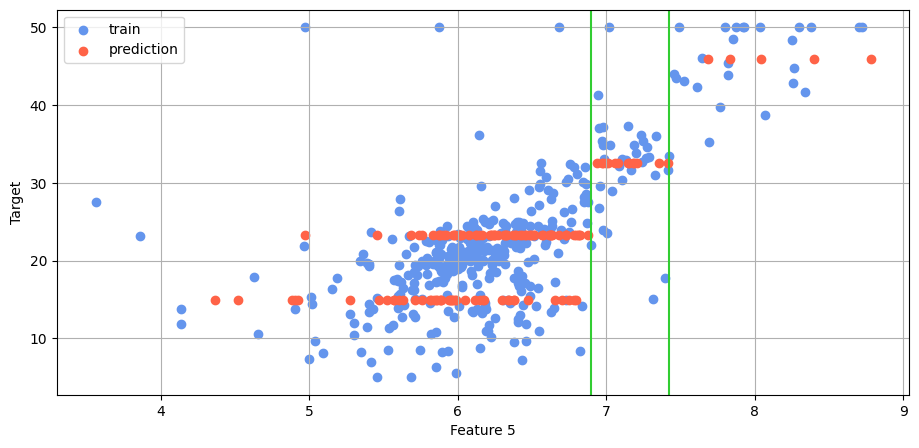

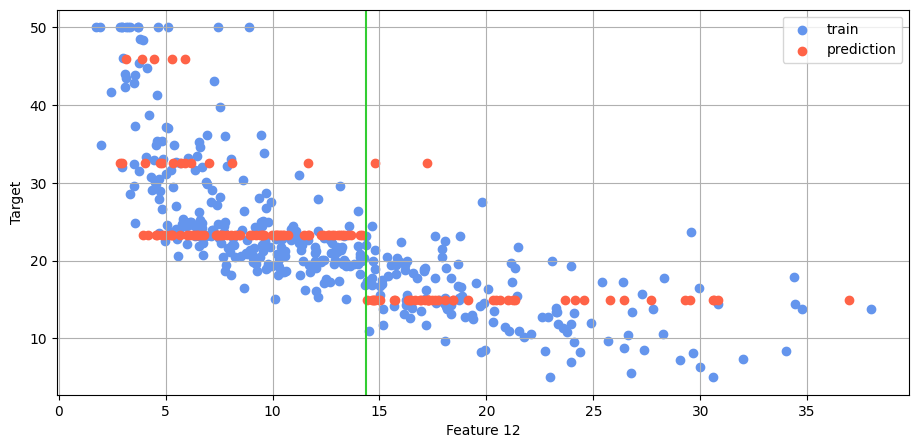

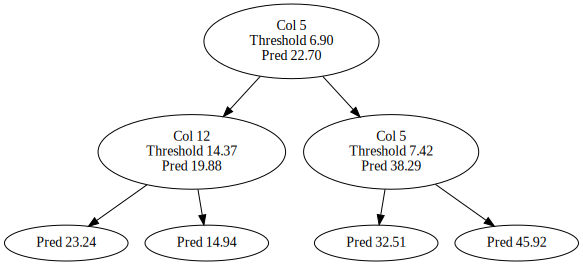

In [169]:
process_model(1)

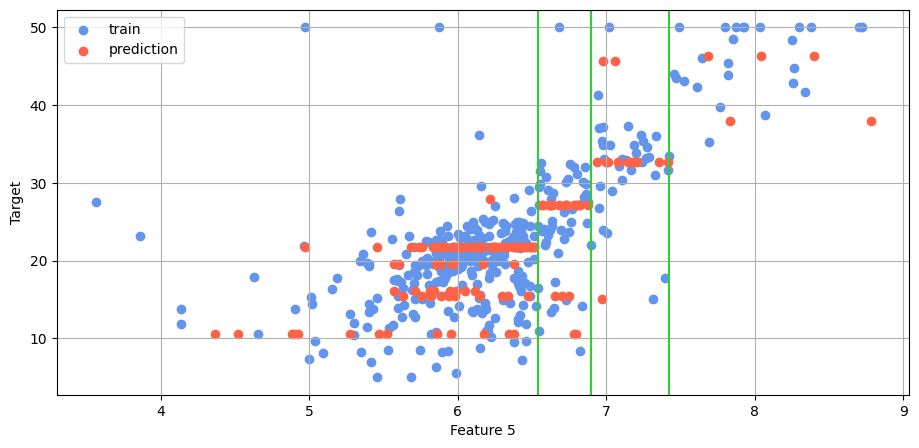

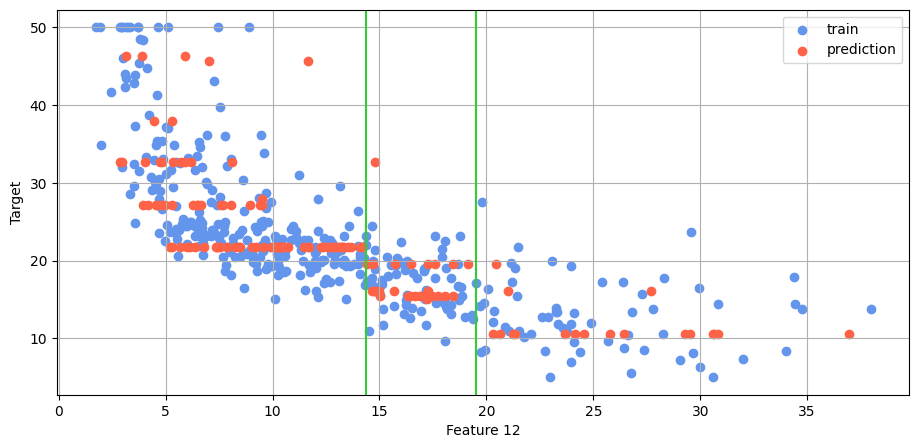

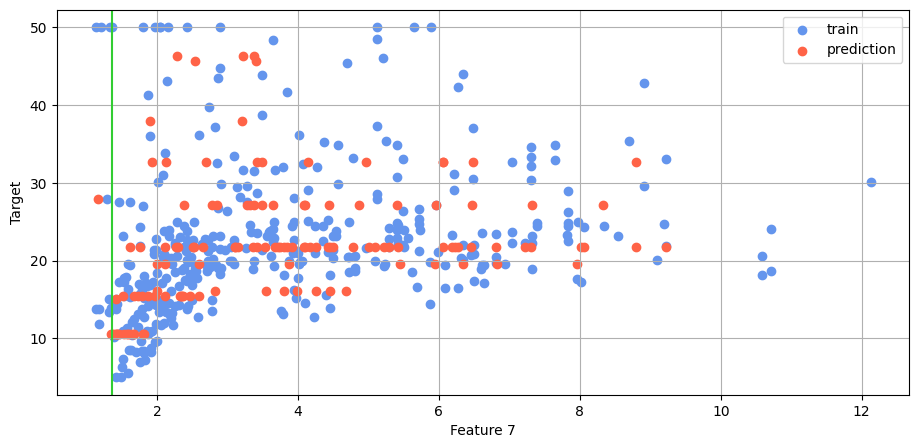

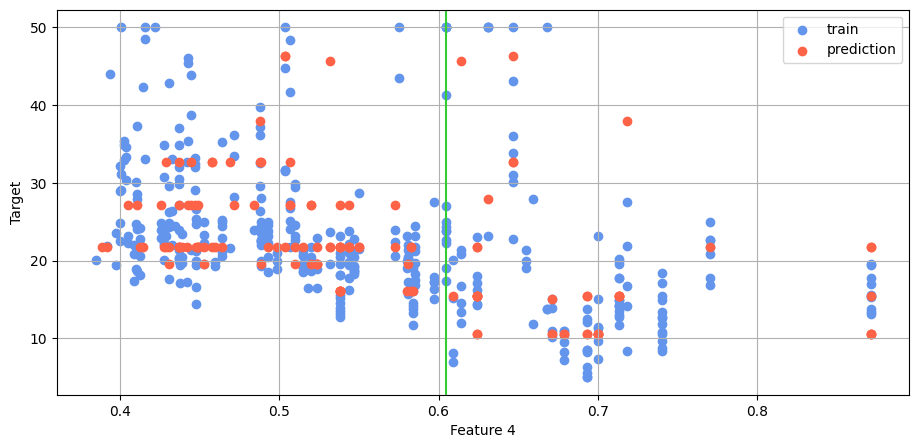

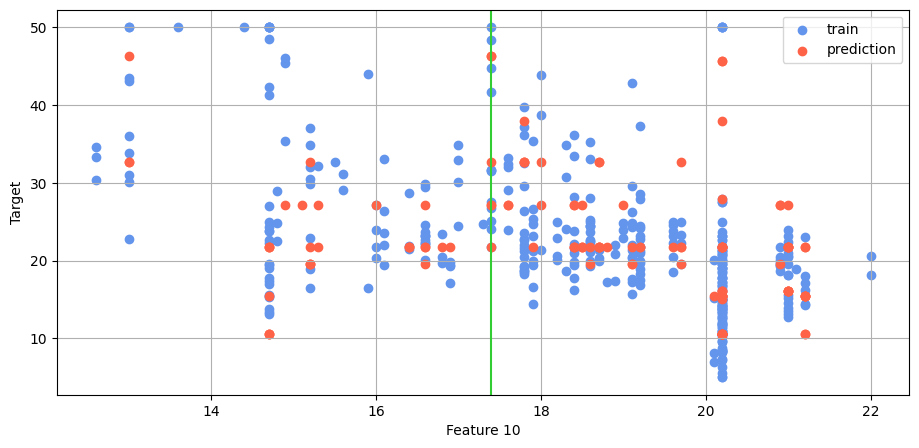

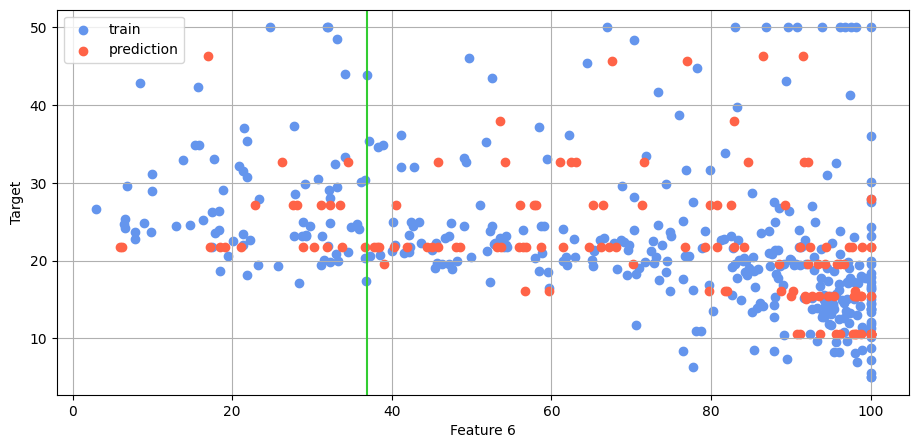

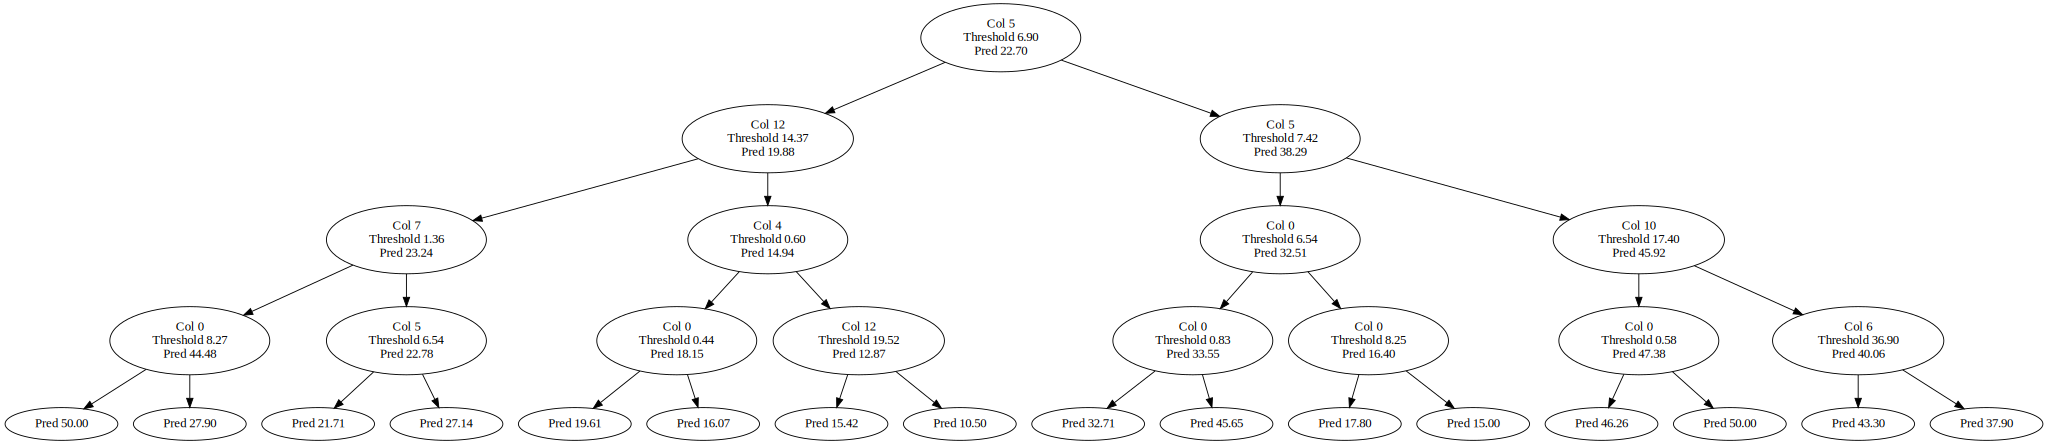

In [170]:
process_model(3)

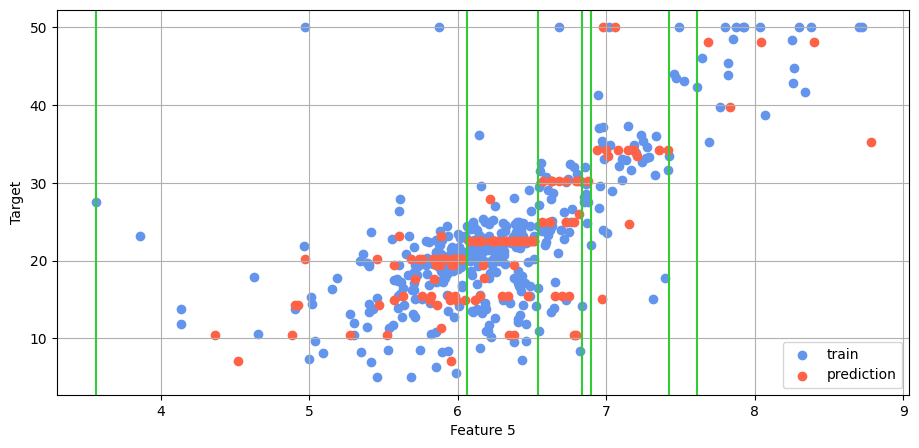

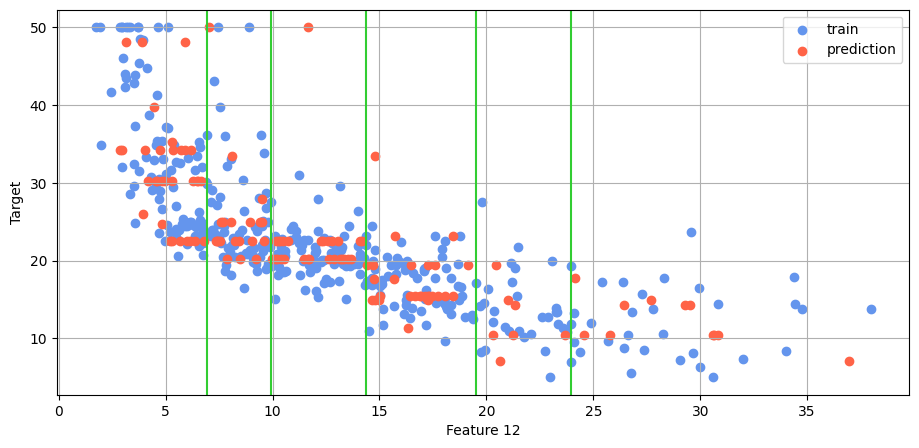

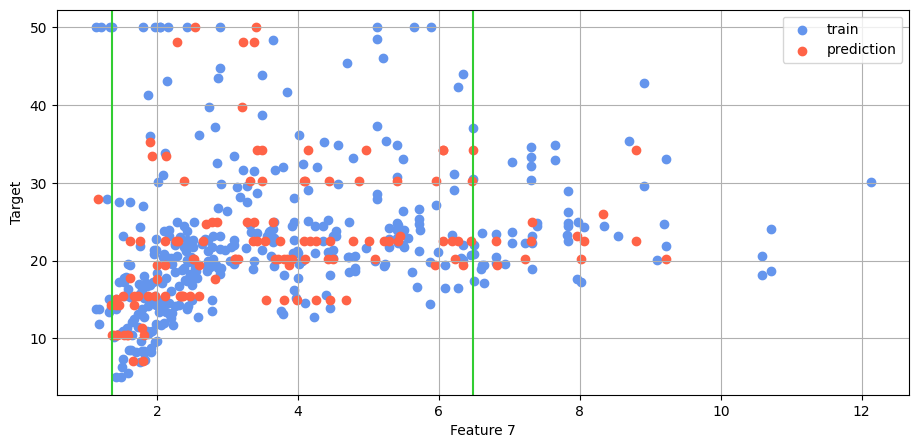

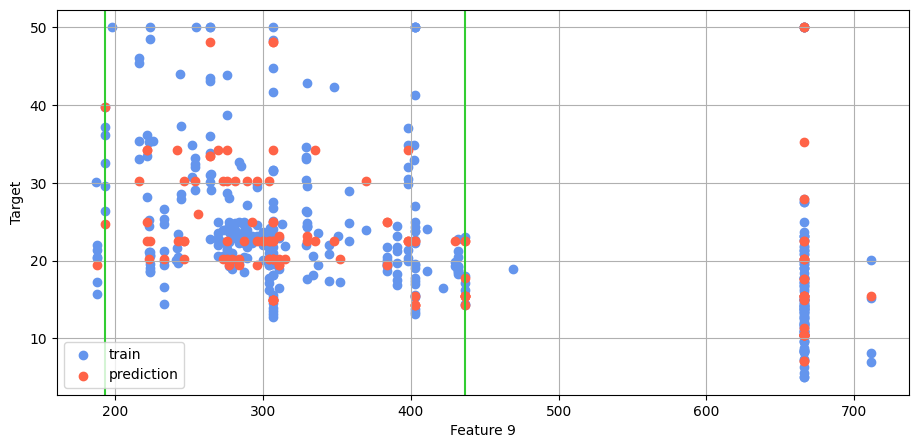

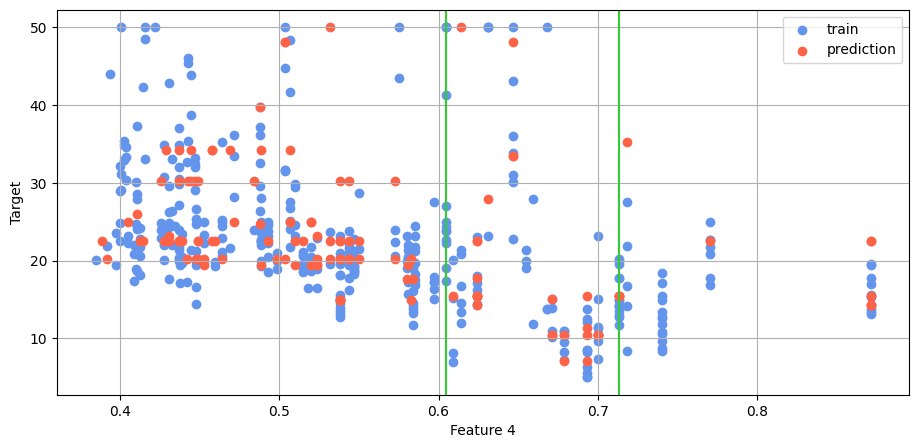

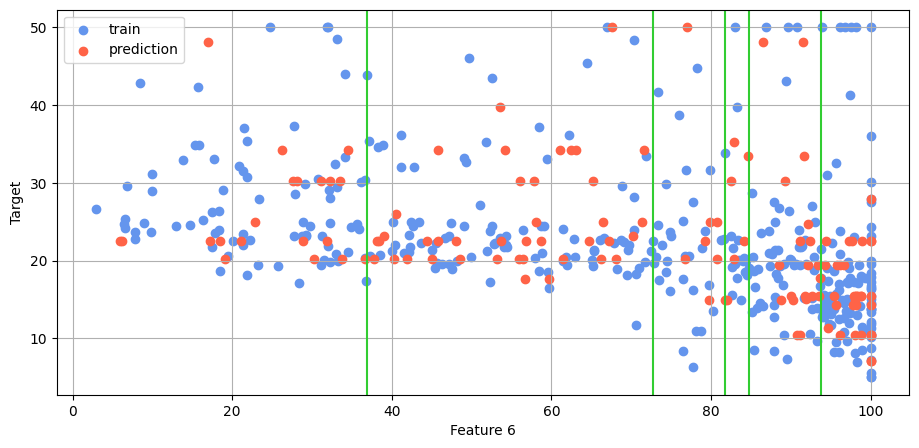

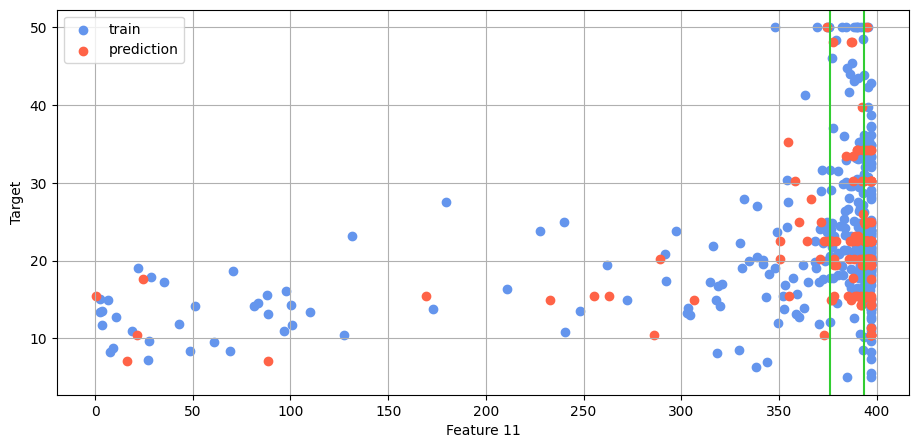

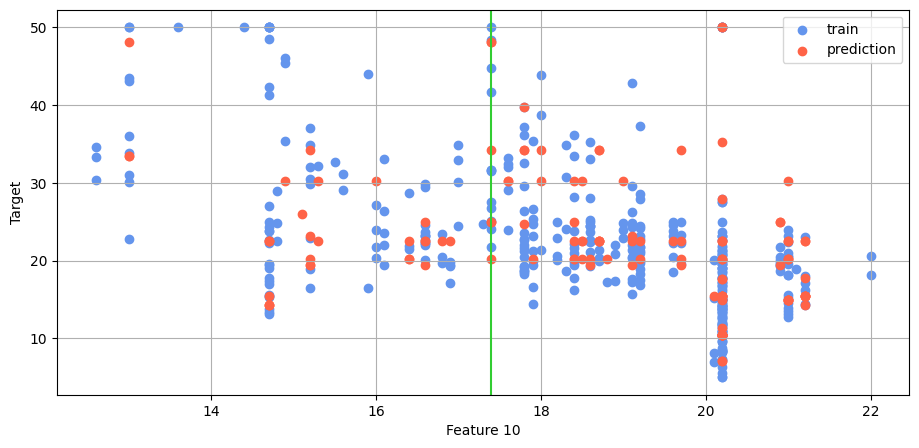

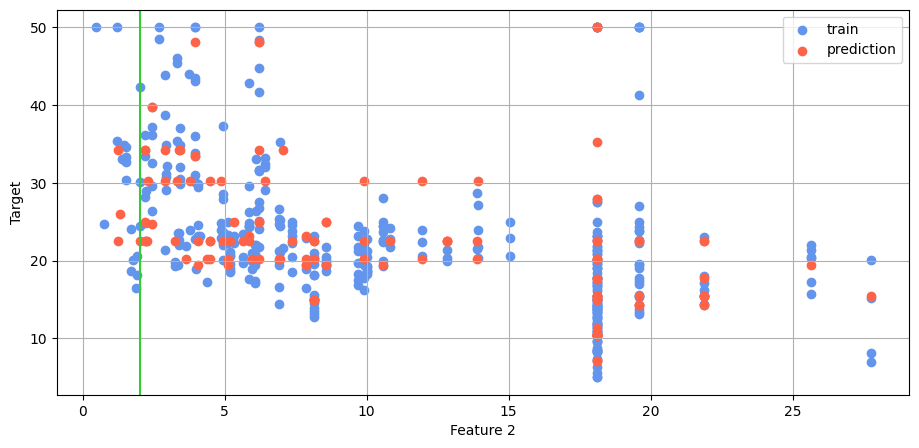

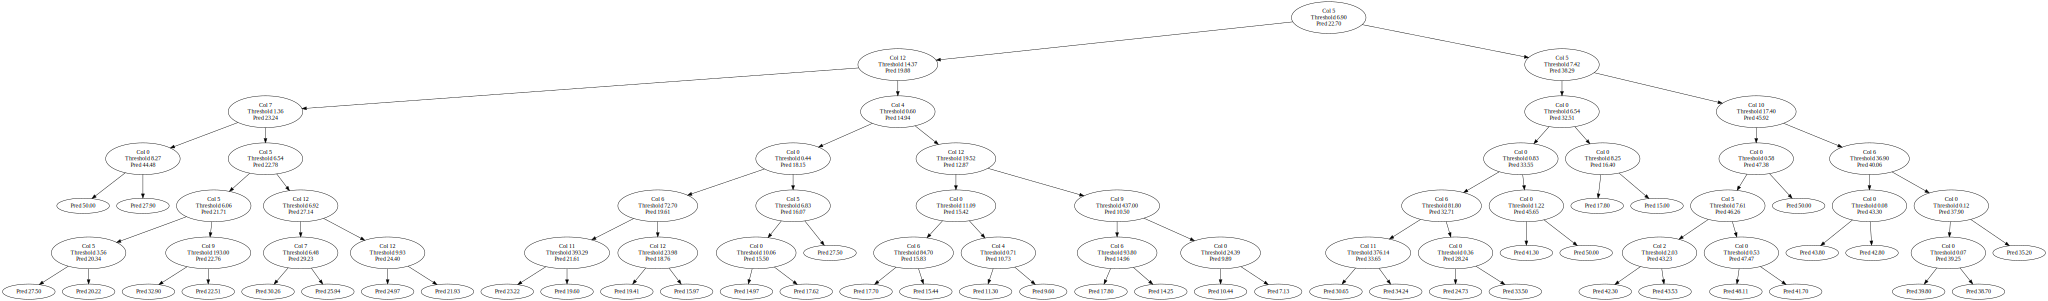

In [171]:
process_model(5)

По графикам фич можно сделать выводы о том, насколько их изменение влияет на результат. В некоторых случаях у нас может быть всего одна разбивка по фиче, в некоторых пять. Соответственно, во втором случае дерево будет более чувствительно к изменению переменной.

### Task 5 <a id="task5"></a>  (0.5 points)

Keep working with boston dataset. 
- Use `GridSearchCV` to find the best hyperparameters among [`max_depth`, `min_samples_leaf`] on 5-Fold cross-validation
- Train the model with the best set of hyperparameters on the whole train dataset. 
- Report `MAE` on test dataset and hyperparameters of the best estimator. 

In [172]:
from sklearn.model_selection import GridSearchCV

search = GridSearchCV(MyDecisionTreeRegressor(), param_grid=dict(max_depth=list(range(2, 20, 3)), min_samples_leaf=list(range(1, 201, 20))), verbose=1)
search.fit(X_train,y_train)
best_model = search.best_estimator_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [173]:
from sklearn.metrics import mean_absolute_error

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print(search.best_params_)
print(mean_absolute_error(y_test, y_pred))

{'max_depth': 5, 'min_samples_leaf': 1}
3.114480827986065


### Task 6 <a id="task6"></a>  (2 points)

Recall definition of bias and variance:
$$
\text{Bias}^2 = \mathbb{E}_{p(x, y)} \left[  (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 \right] \\
\text{Variance} = \mathbb{E}_{p(x, y)} \left[  \mathbb{V}_{\mathbb{X}}( a_{\mathbb{X}}(x))  \right]
$$

We wil now use the following algorithm to estimate bias and variance:

1. Use bootsrap to create `n_iter` samples from the original dataset: $X_1, \dots, X_{n_iter}$
2. For each bootstrapped sample define out-of-bag (OOB) sample $Z_1, \dots, Z_{n_iter}$, which contain all the observations, which did not appear in the corresponding boostraped sample
3. Fit the model on $X_i$s and compute predictions on $Z_i$s
4. For a given *object* $n$:
     - bias^2: squared difference between true value $y_n$ and average prediction (average over the algorithms, for which $n$ was in OOB)
     - variance: variance of the prediction (predictions of the algorithms, for which $n$ was in OOB)
5. Average bias^2 and variance over all the points
    
**Implement `get_bias_variance` function, using the algorithm above**

*Note:*  You can only use 1 loop (for bootsrap iterations). All other operations should be vectorized. 

In [174]:
import warnings
warnings.filterwarnings('ignore')

def get_bias_variance(estimator, x, y, n_iter):
    """ 
    Calculate bias and variance of the `estimator`. 
    Using a given dataset and bootstrap with `n_iter` samples. 

    Parameters
    ----------
    x : ndarray, shape (n_samples, n_features)
        The input samples.
    y : ndarray, shape (n_samples, n_features)
        The input samples.
    n_iter: int
        Number of samples in 
    Returns
    -------
    bias2 : float, 
        Estiamted squared bias
    variance : float, 
        Estiamted variance
    """
    
    all_pred = np.full((n_iter, y.shape[0]), np.nan)
    index = np.arange(y.shape[0])
    
    for i in range(n_iter):
        x_ind = np.random.choice(index, size=len(index), replace=True)
        z_ind = np.setdiff1d(index, x_ind)
        estimator.fit(x[x_ind], y[x_ind])
        all_pred[i][z_ind] = estimator.predict(x[z_ind])
    
    bias_sqr = np.nanmean((np.nanmean(all_pred, axis=0) - y)**2)
    variance = np.nanmean((np.nanmean(all_pred, axis=0) - all_pred)**2)
    return bias_sqr, variance

In [175]:
# Test
estimator = MyDecisionTreeRegressor(max_depth=8, min_samples_split=15)

get_bias_variance(estimator, X_train, y_train, 10)

(15.527029346340775, 10.1750564838544)

### Task 7 <a id="task7"></a>  (0.5 points)

Compute bias and variance for the trees with different min_samples_split. Plot how bias and variance change as min_samples_split increases. 

Comment on what you observe, how does your result correspond to theory?

In [176]:
biases = []
vars = []

for min_split in range(1,30):
    b, v = 0, 0

    for max_depth in range(1, 4):
        model = MyDecisionTreeRegressor(min_samples_split=min_split)
    
        bn, vn = get_bias_variance(model, X_train, y_train, 10)
        
        b += bn
        v += vn
    
    b /= 3
    v /= 3

    biases.append(b)
    vars.append(v)

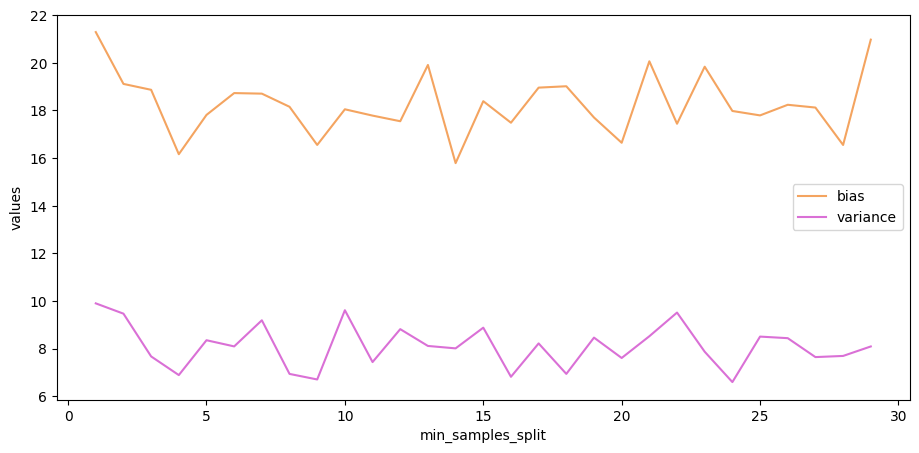

In [177]:
plt.plot(range(1, 30), biases, color='sandybrown', label='bias')
plt.plot(range(1, 30), vars, color='orchid', label='variance')
plt.xlabel('min_samples_split')
plt.ylabel('values')
plt.legend()

Я бы ожидал, что при увеличении min_samples_split понижается переобучение => variance падает, bias растет. На практике на гарфике виндно, что variance в какой-то мере падает, а bias остается примерно тем же.

### Task 8 <a id="task8"></a>  (0.5 points)

Let's try to reduce variance with bagging. Use `sklearn.ensemble.BaggingRegressor` to get an ensemble and compute its bias and variance. 

Answer the following questions:
 - How bagging should affect bias and variance in theory?
 - How bias and variance change (if they change) compared to an individual tree in you experiments? 
 - Do your results align with the theory? Why?

In [178]:
from sklearn.ensemble import BaggingRegressor

model = MyDecisionTreeRegressor(max_depth=5)
model_b = BaggingRegressor(MyDecisionTreeRegressor(max_depth=5))

model_metrics = get_bias_variance(model, X_train, y_train, 10)
model_b_metrics = get_bias_variance(model_b, X_train, y_train, 10)

In [179]:
print(model_metrics)
print(model_b_metrics)

(14.113689955490495, 9.75391731647667)
(13.95635276731383, 3.3643397920394245)


В теории, мы должны снизить variance (без влияния на bias).

На практике, мы снижмаем variance и немого bias.

Кажется, это нормально? Мы получаем более точную модель усредняя деервья. Импортозамещенный Random Forest!

# Part 2. More Ensembles

In this part we will be working with [Billionaires Statistics Dataset](https://www.kaggle.com/datasets/nelgiriyewithana/billionaires-statistics-dataset) to solve a classification task. 

In [180]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('Billionaires Statistics Dataset.csv')

le = LabelEncoder()
y = le.fit_transform(df['selfMade'])
X = df.drop('selfMade', axis=1)
X.head(5)

,rank,finalWorth,category,personName,age,country,city,source,industries,countryOfCitizenship,...,cpi_change_country,gdp_country,gross_tertiary_education_enrollment,gross_primary_education_enrollment_country,life_expectancy_country,tax_revenue_country_country,total_tax_rate_country,population_country,latitude_country,longitude_country
0,1,211000,Fashion & Retail,Bernard Arnault & family,74.0,France,Paris,LVMH,Fashion & Retail,France,...,1.1,"$2,715,518,274,227",65.6,102.5,82.5,24.2,60.7,67059887.0,46.227638,2.213749
1,2,180000,Automotive,Elon Musk,51.0,United States,Austin,"Tesla, SpaceX",Automotive,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
2,3,114000,Technology,Jeff Bezos,59.0,United States,Medina,Amazon,Technology,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
3,4,107000,Technology,Larry Ellison,78.0,United States,Lanai,Oracle,Technology,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
4,5,106000,Finance & Investments,Warren Buffett,92.0,United States,Omaha,Berkshire Hathaway,Finance & Investments,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891


### Task 1 <a id="task2_1"></a> (1 point)

Let's start with data preprocessing. 

0. Drop columns, which are not usefull (e.g. a lot of missing values). Motivate your choice. 
1. Split dataset into train and test
2. You've probably noticed that we have both categorical and numerical columns. Here is what you need to do with them:
    - Categorical: Fill missing values and apply one-hot-encoding (if there are many unique values in a column, you can group them by meaning)
    - Numeric: Fill missing values
    
Use `ColumnTranformer` to define a single transformer for all the columns in the dataset. It takes as input a list of tuples

```
ColumnTransformer([
    ('name1', transform1, column_names1),
    ('name2', transform2, column_names2)
])
```

Pay attention to an argument `remainder='passthrough'`. [Here](https://scikit-learn.org/stable/modules/compose.html#column-transformer) you can find some examples of how to use column transformer. 
    
Since we want to apply 2 transformations to categorical feature, it is very convenient to combine them into a `Pipeline`:

```
double_tranform = make_pipeline(
                        transform_1,
                        transform_2
                        )
```

P.S. Choose your favourite way to fill missing values. 

*Hint* Categorical column usually have `dtype = 'object'`. This may help to obtain list of categorical and numerical columns on the dataset. 

In [181]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2640 entries, 0 to 2639
Data columns (total 34 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rank                                        2640 non-null   int64  
 1   finalWorth                                  2640 non-null   int64  
 2   category                                    2640 non-null   object 
 3   personName                                  2640 non-null   object 
 4   age                                         2575 non-null   float64
 5   country                                     2602 non-null   object 
 6   city                                        2568 non-null   object 
 7   source                                      2640 non-null   object 
 8   industries                                  2640 non-null   object 
 9   countryOfCitizenship                        2640 non-null   object 
 10  organization

"organization", "title", "state", "residenceStateRegion" - много NANов

"lastName", "firstName", "personName", - по большей части уникальные значения, от имени человека не зависит количество его денег

"birthDate", "birthYear", "birthMonth", "birthDay" - все сводятся к agе, либо не имеют особого влияния

In [182]:
X = X.drop(["organization", "title", "state", "residenceStateRegion", "lastName", "firstName", "personName", "birthDate", "birthYear", "birthMonth", "birthDay"], axis=1)

In [183]:
X

,rank,finalWorth,category,age,country,city,source,industries,countryOfCitizenship,status,...,cpi_change_country,gdp_country,gross_tertiary_education_enrollment,gross_primary_education_enrollment_country,life_expectancy_country,tax_revenue_country_country,total_tax_rate_country,population_country,latitude_country,longitude_country
0,1,211000,Fashion & Retail,74.0,France,Paris,LVMH,Fashion & Retail,France,U,...,1.1,"$2,715,518,274,227",65.6,102.5,82.5,24.2,60.7,6.705989e+07,46.227638,2.213749
1,2,180000,Automotive,51.0,United States,Austin,"Tesla, SpaceX",Automotive,United States,D,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,3.282395e+08,37.090240,-95.712891
2,3,114000,Technology,59.0,United States,Medina,Amazon,Technology,United States,D,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,3.282395e+08,37.090240,-95.712891
3,4,107000,Technology,78.0,United States,Lanai,Oracle,Technology,United States,U,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,3.282395e+08,37.090240,-95.712891
4,5,106000,Finance & Investments,92.0,United States,Omaha,Berkshire Hathaway,Finance & Investments,United States,D,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,3.282395e+08,37.090240,-95.712891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2635,2540,1000,Healthcare,51.0,China,Shanghai,Health clinics,Healthcare,China,D,...,2.9,"$19,910,000,000,000",50.6,100.2,77.0,9.4,59.2,1.397715e+09,35.861660,104.195397
2636,2540,1000,Food & Beverage,80.0,United States,Pottsville,Beer,Food & Beverage,United States,E,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,3.282395e+08,37.090240,-95.712891
2637,2540,1000,Manufacturing,60.0,China,Gaomi,Tyre manufacturing machinery,Manufacturing,China,R,...,2.9,"$19,910,000,000,000",50.6,100.2,77.0,9.4,59.2,1.397715e+09,35.861660,104.195397
2638,2540,1000,Real Estate,71.0,China,Nanjing,Real estate,Real Estate,China,D,...,2.9,"$19,910,000,000,000",50.6,100.2,77.0,9.4,59.2,1.397715e+09,35.861660,104.195397


In [184]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

onehot = make_pipeline(SimpleImputer(strategy = 'constant'), OneHotEncoder(drop = 'if_binary'))

column_transformer = ColumnTransformer(
    [('onehot', onehot, X.select_dtypes('object').columns), 
     ('fillnan', SimpleImputer(strategy = 'mean'), X.select_dtypes('float64').columns)],
    remainder = 'passthrough')

column_transformer.fit_transform(X)

<2640x1930 sparse matrix of type '<class 'numpy.float64'>'
	with 57745 stored elements in Compressed Sparse Row format>

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

X_train = column_transformer.transform(X_train)
X_test = column_transformer.transform(X_test)

### Task 2 <a id="task2_2"></a> (0.7 points)

Fit and compare 5 different models (use sklearn): Gradient Boosting, Random Forest, Decision Tree, SVM, Logitics Regression
    
* Choose one classification metric and justify your choice .
* Compare the models using score on cross validation. Mind the class balance when choosing the cross validation. (You can read more about different CV strategies [here](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold))
* Which model has the best performance? Which models overfit or underfit?

In [186]:
print(list(y).count(0))
print(list(y).count(1))

# Classes are imbalanced

828
1812


In [187]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

def analyze_model(model, X_train, y_train, X_test, y_test, name=None):
    ac, f1 = [], []

    # StratifiedKFold
    for train, test in StratifiedKFold().split(X_train, y_train):
        model.fit(X_train[train], y_train[train])

        ac.append(accuracy_score(model.predict(X_train[test]), y_train[test]))
        f1.append(f1_score(model.predict(X_train[test]), y_train[test]))

    bias, variance = get_bias_variance(model, X_test, y_test, 10)

    print(f"""Model: {name if name else type(model)}
    Accuracy with CV: {np.mean(ac)}
    Accuracy on test: {accuracy_score(model.predict(X_test), y_test)}
    F1 with CV: {np.mean(f1)}
    F1 on test: {f1_score(model.predict(X_test), y_test)}
    Bias: {bias}
    Variance: {variance}
    """)

In [188]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

models = [
    LogisticRegression(random_state=42),
    SVC(random_state=42),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
]

for model in models:
    analyze_model(model, X_train, y_train, X_test, y_test)

Model: <class 'sklearn.linear_model._logistic.LogisticRegression'>
    Accuracy with CV: 0.6822919117564675
    Accuracy on test: 0.7026515151515151
    F1 with CV: 0.8111454303977756
    F1 on test: 0.8253615127919911
    Bias: 0.29942418426103645
    Variance: 0.0
    


Model: <class 'sklearn.svm._classes.SVC'>
    Accuracy with CV: 0.6822919117564675
    Accuracy on test: 0.7026515151515151
    F1 with CV: 0.8111454303977756
    F1 on test: 0.8253615127919911
    Bias: 0.2980769230769231
    Variance: 0.0
    
Model: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
    Accuracy with CV: 0.7727191242871388
    Accuracy on test: 0.8920454545454546
    F1 with CV: 0.8355715547886815
    F1 on test: 0.9220246238030095
    Bias: 0.17830784484930629
    Variance: 0.07457315568714531
    
Model: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
    Accuracy with CV: 0.8039673736457038
    Accuracy on test: 0.9128787878787878
    F1 with CV: 0.8616605187318587
    F1 on test: 0.9394736842105262
    Bias: 0.20241747612506542
    Variance: 0.04830869847939176
    
Model: <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
    Accuracy with CV: 0.7982824106752714
    Accuracy on test: 0.865530303030303
    F1 with CV: 0.8635953789253064
    

Классы не сбалансированы. Для этого при обучении используем StratifiedKFold, но accuracy все равно получается довольно большим (не обязательно потому, что модель хороша, а потому что угадать класс которого больше - проще). => предлагаю смотреть на метрику F1.

По этой метрике лучше всего себя показывают деревянные модели - DecisionTreeClassifier и RandomForest. Хуже всего - SVC/LogisticRegression.

Самая переобученная (высокая Variance) - DecisionTreeClassifier, недообученная (высокая Bias) - SVC/LogisticRegression.


### Task 3 <a id="task2_3"></a> (0.5 points)

More Gradient Boosting. You will have to take one of the three popular boosting implementations (xgboost, lightgbm, catboost). Select hyperparameters (number of trees, learning rate, depth) on cross-validation and compare with the methods from the previous task. 

In [189]:
from catboost import CatBoost, Pool

cat = CatBoost()

cat_gcv = cat.grid_search(
        {
            "depth": range(2, 13, 3),
            "num_trees": range(50, 200, 50),
            "learning_rate": [0.0001, 0.001, 0.1]
        },
        X_train, y_train,
        cv = StratifiedKFold(n_splits = 3),
        partition_random_seed = 69,
        search_by_train_test_split = False, # Recomended for small datasets
        stratified = True, train_size = 0.8, verbose = False)

Training on fold [0/3]
0:	learn: 0.8256662	test: 0.8265257	best: 0.8265257 (0)	total: 1.92ms	remaining: 94ms
1:	learn: 0.8256083	test: 0.8264671	best: 0.8264671 (1)	total: 3.69ms	remaining: 88.5ms
2:	learn: 0.8255495	test: 0.8264084	best: 0.8264084 (2)	total: 4.87ms	remaining: 76.3ms
3:	learn: 0.8254926	test: 0.8263519	best: 0.8263519 (3)	total: 6.58ms	remaining: 75.6ms
4:	learn: 0.8254338	test: 0.8262932	best: 0.8262932 (4)	total: 8.79ms	remaining: 79.1ms
5:	learn: 0.8253760	test: 0.8262353	best: 0.8262353 (5)	total: 10.5ms	remaining: 76.8ms
6:	learn: 0.8253178	test: 0.8261765	best: 0.8261765 (6)	total: 11.9ms	remaining: 73.4ms
7:	learn: 0.8252591	test: 0.8261179	best: 0.8261179 (7)	total: 13.1ms	remaining: 68.8ms
8:	learn: 0.8252013	test: 0.8260594	best: 0.8260594 (8)	total: 14.3ms	remaining: 65.3ms
9:	learn: 0.8251417	test: 0.8259998	best: 0.8259998 (9)	total: 15.5ms	remaining: 62.1ms
10:	learn: 0.8250827	test: 0.8259400	best: 0.8259400 (10)	total: 16.7ms	remaining: 59.3ms
11:	learn

In [190]:
params = cat_gcv['params']
params

{'depth': 8, 'iterations': 150, 'learning_rate': 0.1}

In [191]:
pred = cat.predict(X_test, prediction_type = 'Probability')
pred = np.where(pred[:,0] < pred[:, 1], 0, 1)

In [192]:
accuracy_score(y_test, pred)

0.2840909090909091

In [193]:
f1_score(y_test, pred)

0.0

Кажется, что catboost очень плохо показал себя. Возможно, я неправильно его готовлю?

### Task 4 <a id="task2_4"></a> (0.7 points)

Now let's train more fancy ensembles:

* Bagging with decision trees as base estimators
* Bagging with gradient boosting (with large amount of trees, >100) as base estimators
* [Voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) 
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Logistic Regression as a final model
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Gradeint Boosting as a final model


If not stated in the task, feel free to tune / choose hyperparameters and base models.

Answer the questions:
* Which model has the best performance?
* Does bagging reduce overfiting of the gradient boosting with large amount of trees? 
* What is the difference between voting and staking? 

In [194]:
def prepape_cl(models):
    return [(m.__class__.__name__, m) for m in models]

In [195]:
from sklearn.ensemble import BaggingClassifier, VotingClassifier, StackingClassifier

models = [
    BaggingClassifier(DecisionTreeClassifier(random_state=42)),
    BaggingClassifier(GradientBoostingClassifier(random_state=42, n_estimators=256)),
    VotingClassifier(
        prepape_cl(
            [
                GradientBoostingClassifier(random_state=42),
                LogisticRegression(random_state=42),
                DecisionTreeClassifier(random_state=42),
                RandomForestClassifier(random_state=42)
            ],
        ),
        voting='soft'),
    StackingClassifier(
        prepape_cl(
            [
                GradientBoostingClassifier(random_state=42),
                DecisionTreeClassifier(random_state=42),
                RandomForestClassifier(random_state=42)
            ],
        ),
        LogisticRegression(random_state=42)),
    StackingClassifier(
        prepape_cl(
            [
                LogisticRegression(random_state=42),
                DecisionTreeClassifier(random_state=42),
                RandomForestClassifier(random_state=42)
            ],
        ), GradientBoostingClassifier(random_state=42)),
]

names = [
    "Bagging/DecisionTree",
    "Bagging/GB",
    "Voting",
    "Stacking/Logistic",
    "Stacking/GB"
]

In [196]:
for name, model in zip(names, models):
    analyze_model(model, X_train, y_train, X_test, y_test, name=name)

Model: Bagging/DecisionTree
    Accuracy with CV: 0.7902356223320225
    Accuracy on test: 0.8958333333333334
    F1 with CV: 0.849904038135788
    F1 on test: 0.9245541838134431
    Bias: 0.17508325637457026
    Variance: 0.062325429153331405
    
Model: Bagging/GB
    Accuracy with CV: 0.7982857719068266
    Accuracy on test: 0.9071969696969697
    F1 with CV: 0.8626625889759477
    F1 on test: 0.9356110381077529
    Bias: 0.18194469645729547
    Variance: 0.04021033802121885
    
Model: Voting
    Accuracy with CV: 0.789289995854481
    Accuracy on test: 0.9053030303030303
    F1 with CV: 0.8507446959526828
    F1 on test: 0.9348958333333333
    Bias: 0.17610195443256668
    Variance: 0.06193365111464202
    
Model: Stacking/Logistic
    Accuracy with CV: 0.812017523220508
    Accuracy on test: 0.9128787878787878
    F1 with CV: 0.8685568765566971
    F1 on test: 0.9385026737967915
    Bias: 0.17683630547457077
    Variance: 0.055177229703356756
    
Model: Stacking/GB
    Accuracy 

Наилучшие метрики показывает Voting-модель, с сравнительно низким variance и высоким Accuracy/F1.

Bagging для градиентного бустинга с большим набором деревьев, теоретически, не должен уменьшать переобучение, особенно если деревьев много.

Voting просто смотрит на предсказание моделей и выбирает самое популярное, а Stacking - пропихивает через дополнительную модель.

### Task 5 <a id="task2_5"></a> (0.1 points)

Report the test score for the best model, that you were able to train. 

Кажется, что лучшая модель - из прошлого пункта:

```
Model: Voting
    Accuracy with CV: 0.7916753498481844
    Accuracy on test: 0.9299242424242424
    F1 with CV: 0.851187938938662
    F1 on test: 0.950863213811421
    Bias: 0.19515135404066022
    Variance: 0.07065991751031121
    